In [8]:
import alpdesign as alp
from alpdesign.seq import *
from alpdesign.mlp import *
from alpdesign.utils import *
import jax 
from jax_unirep import get_reps
import haiku as hk

In [9]:
def hamming(seq1, seq2): # seq1 and seq2 are of same length
    seqlist1 = list(seq1)
    seqlist2 = list(seq2)
    hamming_distance = 0.
    for i in range(len(seqlist1)):
        if seqlist1[i] == seqlist2[i]:
            continue
        hamming_distance += 1.
    return hamming_distance / len(seqlist1)
    

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.plot(losses)

In [11]:
key = jax.random.PRNGKey(0)
batch_size = 16
bag_num = 6
target_seq = 'GIGAVLKVLTTGLPALISWIKRKRQQ'
oh_vec = encode_seq(list(target_seq))
oh_unirep = seq2useq(oh_vec)
target_rep = differentiable_jax_unirep(oh_unirep)
print(target_rep.shape)
seqs = ['GIGAVLKVLKAGLPALIVTLKRKIVQ',
       'PPGATLKKHTTGSVALISWIWARIQQ',
       'GIGAVLKVLTTGLKTLISAAKRKRAA',
       'HAPPVLKVLTTGLAPPLVWIKRKRTH',
       'GIGAVLUIHKLSSVAAWRPPKRKRQQ']


#plt.rcParams["figure.figsize"] = (12,12)
#fig, axs = plt.subplots(3)

#@jax.jit
def single_loop(key, seqs):

    # get labels
    labels = []
    for seq in seqs:
        labels.append(hamming(target_seq, seq))
    labels = jnp.array(labels)
    reps = get_reps(seqs)[0][0]
    key, _ = jax.random.split(key, num=2)
    forward = hk.without_apply_rng(hk.transform(alp.model_forward))
    params, mlp_loss = alp.ensemble_train(key, forward, reps, labels)
    #axs[i].plot(mlp_loss)
    final_vec = alp.bayes_opt(forward, params, labels)
    print(final_vec.shape)
    
    # need to adjust length in the future
    logits = jax.random.normal(key, shape=(jnp.shape(oh_vec)))
    b_logits = jax.random.normal(key, shape=(batch_size,*jnp.shape(oh_vec)))
    params = forward_seqprop.init(key, logits)
    #loss_traces, loss, _seqs = pso_train(key, final_vec, b_logits, params, alp.seq.train_seqprop, batch_size, bag_num)
    loss_traces, loss, _seqs = pso_train(key, final_vec, b_logits, params, batch_size, bag_num)
    gen_seqs = []
    for seq in _seqs:
        seq = alp.utils.decode_seq(seq)
        str = ""
        gen_seqs.append(str.join(seq))
    # add data points
    seqs = [*seqs, *gen_seqs]
    return seqs, mlp_loss, loss_traces

    
# for i in range(3):
#     losses = []
#     key, _ = jax.random.split(key, num=2)
#     seqs, mlp_loss = single_loop(key, seqs)
#     print(seqs)
#     losses.append(mlp_loss)
#     #axs[i].plot(mlp_loss)

(1, 1900)


In [13]:
a = jnp.ones((1900,))
print(a.reshape((1, 1900)))

[[1. 1. 1. ... 1. 1. 1.]]


In [12]:
loop_mlp_loss = []
loop_seq_loss = []
for i in range(3):
    key, _ = jax.random.split(key, num=2)
    seqs, mlp_loss, loss_traces= single_loop(key, seqs)
    loop_mlp_loss.append(mlp_loss)
    loop_seq_loss.append(loss_traces)
#     #axs[i].plot(mlp_loss)

ValueError: Input must not be scalar.

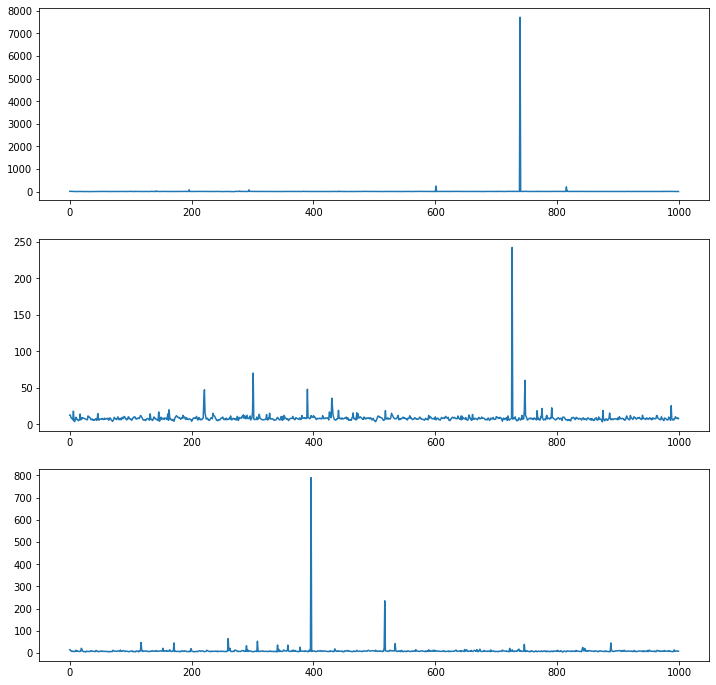

In [6]:
plt.rcParams["figure.figsize"] = (12, 12)
fig, axs = plt.subplots(3)
for i in range(3):
    axs[i].plot(loop_mlp_loss[i])

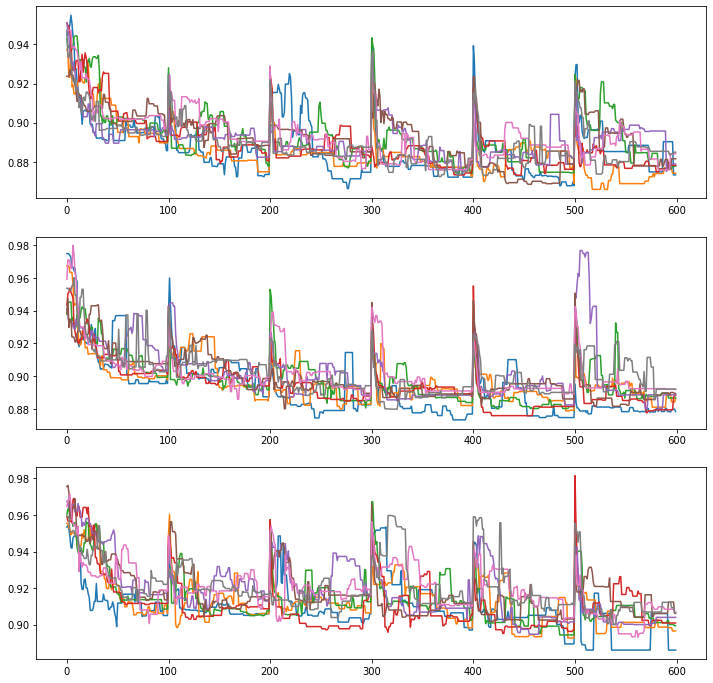

In [7]:
plt.rcParams["figure.figsize"] = (12, 12)
fig, axs = plt.subplots(3)
for i in range(3):
    for j in range(8):
        axs[i].plot(loop_seq_loss[i][j])